In [103]:
#!pip install -q texttable

In [104]:
from tabulate import tabulate
from texttable import Texttable
import latextable

from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms

In [105]:
def plot_dist(G):
    M = nx.to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    
    fig = plt.figure(figsize=(16, 6)) 
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()

In [106]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti

    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

# Load dataset and pre-process, dropping noise rows

In [107]:
leg = 'xvii'
year = 'xvii (from april 28)'
#y = pd.read_csv(f'./{leg}-years/{leg}-{year}.csv')

y = pd.read_csv(f'./{leg}-years/{leg}-merged.csv')

print(y.shape)





(671, 24938)


In [108]:
nan_count = y.isnull().sum(axis=1)
p = 0.8
l = len(y.columns[4:])
df = y.drop(nan_count[nan_count >= p*l].index, axis = 0)

df.shape


(247, 24938)

In [109]:
#mapping to categorical values
dizionario_espressioni = {'Assente': np.float64(0), 'Favorevole': np.float64(1), 'Non ha votato': np.float64(0), 'Contrario': np.float64(3), 'Astensione': np.float64(4), 'In missione': np.float64(0)}
for i in df.columns[4:]:
    df[i] = df[i].map(dizionario_espressioni)

df = df.replace(np.nan, 0)

In [110]:
df.head()

,Parlamentare,id,Partito,dataIngresso,010001,013001,015028,015015,015039,015033,...,905008,905001,905002,905009,009002,009004,009005,009006,009003,009001
1,BERSANI PIER LUIGI,300026,MDP-LU,2017-02-28,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,3.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,3.0
4,CATANOSO GENOESE FRANCESCO,300237,FI-PDL,2013-03-19,1.0,1.0,0.0,3.0,0.0,0.0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,D'ALIA GIANPIERO,300239,DES-CD,2013-12-10,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BIANCHI DORINA,300274,AP-CPE-NCD-NCI,2013-11-18,1.0,1.0,3.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,CIRIELLI EDMONDO,300319,FDI-AN,2013-04-03,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0


In [111]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.2*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.shape

(182, 24938)

# Extract party alignment for each voting

In [112]:
#works only with dataframes like ours
def alignment_parties(df):
    col = df.columns[4:].to_list()
    col.append('Partito')
    parties_alignment = pd.DataFrame()
    party = df.groupby('Partito')
    for i in party: # party[0] nome partito, party[1] dataframe
        a = np.apply_along_axis(statistics.mode, axis = 0, arr= i[1])[4:].tolist()
        a.append(i[0])
        parties_alignment = pd.concat([parties_alignment, pd.DataFrame(a).T], axis = 0)

    parties_alignment.columns = col
    return parties_alignment


In [113]:
alignment = alignment_parties(df)
alignment

,010001,013001,015028,015015,015039,015033,015004,015025,015021,015020,...,905001,905002,905009,009002,009004,009005,009006,009003,009001,Partito
0,1.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,AP-CPE-NCD-NCI
0,1.0,1.0,3.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CI
0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,DES-CD
0,1.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,FI-PDL
0,4.0,4.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,...,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,LNA
0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,...,3.0,1.0,4.0,4.0,4.0,4.0,1.0,4.0,0.0,M5S
0,1.0,1.0,0.0,3.0,0.0,3.0,3.0,3.0,3.0,1.0,...,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,MDP-LU
0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,MISTO
0,4.0,4.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,3.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NCI-SCPI-MAIE
0,1.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,PD


## Partisan discipline

In [114]:
discipline = []
for index, row in df.iterrows():
    p = alignment[alignment['Partito'] == row['Partito']]
    c = 0
    for i in p.drop('Partito', axis = 1).columns:
        if row[i] == np.float64(p[i][0]):
            c+=1
    
    discipline.append(c/(len(p.columns) - 1))

df['discipline'] = discipline

In [115]:
print(df['discipline'].mean(), df['discipline'].std())

0.7102508865162271 0.16391670000247943


# Graph based on similarity

In [116]:
df

,Parlamentare,id,Partito,dataIngresso,010001,013001,015028,015015,015039,015033,...,905001,905002,905009,009002,009004,009005,009006,009003,009001,discipline
0,BERSANI PIER LUIGI,300026,MDP-LU,2017-02-28,1.0,0.0,0.0,3.0,0.0,0.0,...,3.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,3.0,0.732534
1,CATANOSO GENOESE FRANCESCO,300237,FI-PDL,2013-03-19,1.0,1.0,0.0,3.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.819363
3,BIANCHI DORINA,300274,AP-CPE-NCD-NCI,2013-11-18,1.0,1.0,3.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711438
8,BURTONE GIOVANNI MARIO SALVINO,300410,PD,2013-03-19,1.0,1.0,3.0,3.0,1.0,3.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.749058
11,CAPODICASA ANGELO,301478,MDP-LU,2017-02-28,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,ALTIERI TRIFONE,306743,FI-PDL,2013-03-19,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557071
243,BERGONZI MARCO,306821,PD,2013-03-19,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441445
244,BOLDRINI PAOLA,306841,PD,2013-03-19,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552699
245,BRIGNONE BEATRICE,306881,SI-SEL-POS-LU,2013-03-19,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631988


In [117]:
m = np.array(df[df.columns[4:df.shape[1]-1]])
m.shape

(182, 24934)

In [118]:
A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i],m[j])

In [119]:
unique_scores, counts = np.unique(A, return_counts=True)
distribution = dict(zip(unique_scores, counts / np.sum(counts)))

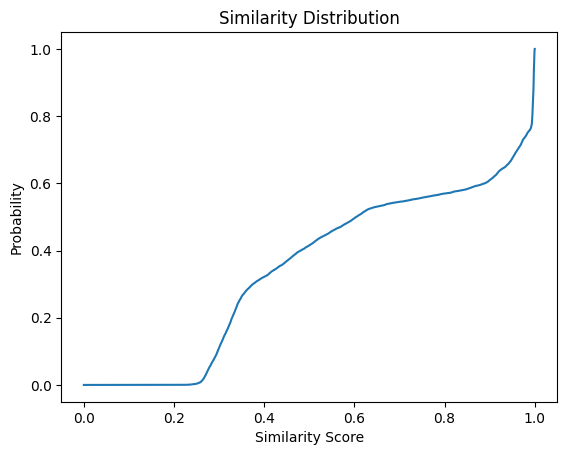

In [120]:
scores = list(distribution.keys())
probabilities = np.cumsum(list(distribution.values()))

plt.plot(scores, probabilities)
plt.xlabel('Similarity Score')
plt.ylabel('Probability')
plt.title('Similarity Distribution')
plt.show()

182
16651
16469
182


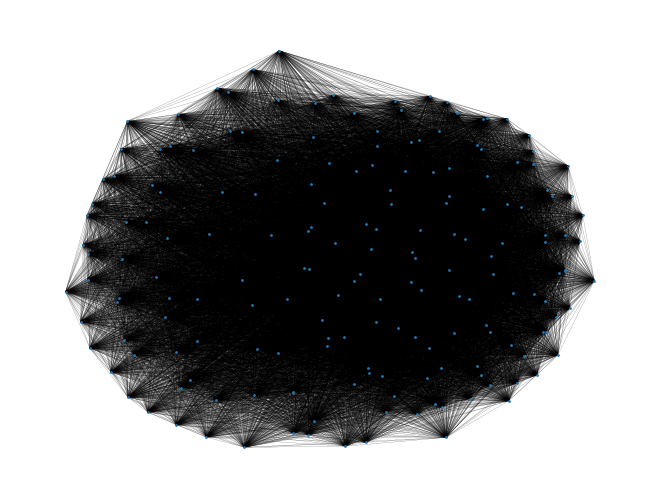

In [121]:
G = nx.from_numpy_matrix(A)

print(G.number_of_nodes())
print(G.number_of_edges())
G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())
print(G.number_of_nodes())

nx.draw(G, node_size = 1, width = 0.1)

16469
8256


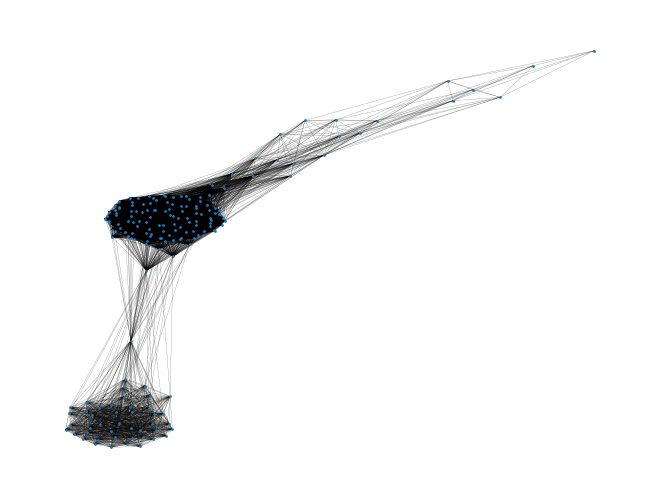

In [122]:
F = G.copy()
tresh = 0.6
threshold = tresh
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

Degree Distribution Analysis

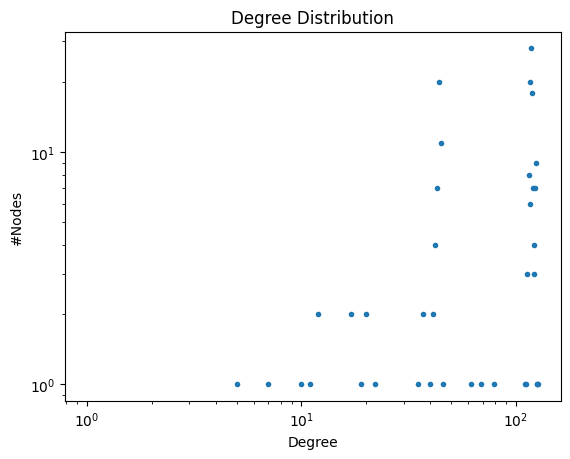

In [123]:
hist = nx.degree_histogram(F)   
plt.plot(range(0, len(hist)), hist, '.')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [124]:
n_nodes = F.number_of_nodes()
n_edges = F.number_of_edges()
avg_deg = sum(dict(F.degree()).values())/float(len(F))
n_comps = nx.number_connected_components(F)
comps = list(nx.connected_components(F)) # get a list of connected components (for decreasing size)
avg_spl = nx.average_shortest_path_length(F.subgraph(comps[0])) #giant component
diam = nx.diameter(F.subgraph(comps[0])) # we compute the diameter on the giant component
avg_cc = nx.average_clustering(F) # compute the global clustering coefficient
density = nx.density(F)

To print the table in Latex:

In [125]:
rows = [['year','#nodes', '#edges', 'avg degree', '#conn. comps.','avg SPL','diameter', 'avg CC', 'Density'],
         [year,n_nodes,n_edges,avg_deg,n_comps, avg_spl, diam, avg_cc,density]]

In [126]:
print('Tabulate Table:')
print(tabulate(rows, headers='firstrow'))

table = Texttable()
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print(tabulate(rows, headers='firstrow', tablefmt='latex'))


Tabulate Table:
year                    #nodes    #edges    avg degree    #conn. comps.    avg SPL    diameter    avg CC    Density
--------------------  --------  --------  ------------  ---------------  ---------  ----------  --------  ---------
xvii (from april 28)       182      8256       90.7253                1    1.75806           5   0.94037   0.501245
\begin{tabular}{lrrrrrrrr}
\hline
 year                 &   \#nodes &   \#edges &   avg degree &   \#conn. comps. &   avg SPL &   diameter &   avg CC &   Density \\
\hline
 xvii (from april 28) &      182 &     8256 &      90.7253 &               1 &   1.75806 &          5 &  0.94037 &  0.501245 \\
\hline
\end{tabular}


# Comparison with syntetic graphs

# ER

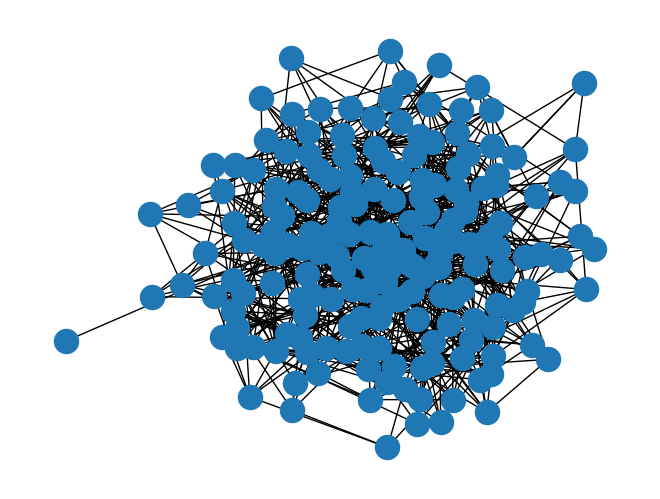

In [127]:
# network generators 1 (random graphs)
p = 0.05 # cambiare p 
er = nx.erdos_renyi_graph(F.number_of_nodes(), p)
nx.draw(er)

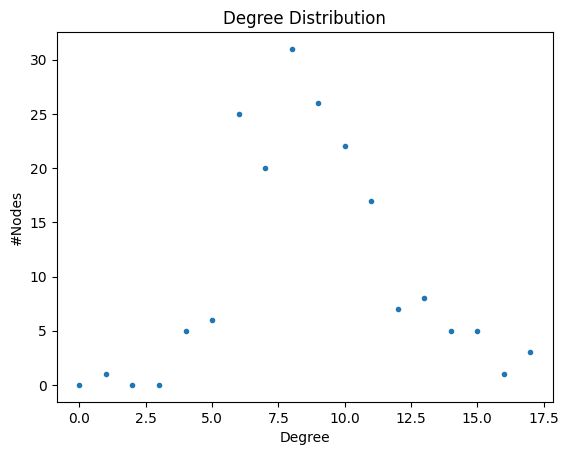

In [128]:
hist = nx.degree_histogram(er)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# BA

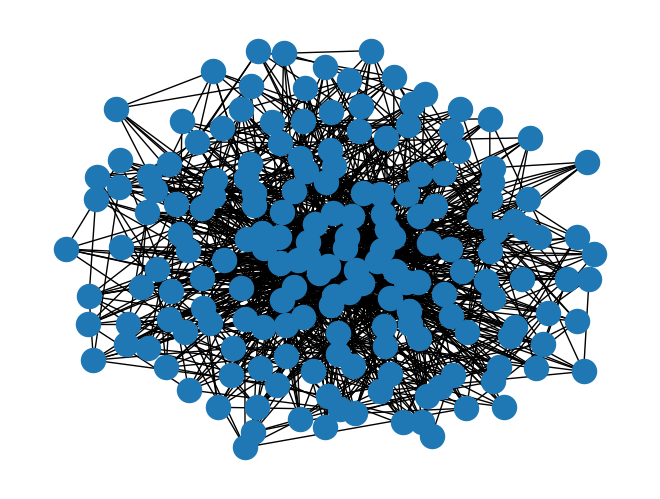

In [129]:
m = 7  # number of links each node establishes once joining the network
ba = nx.barabasi_albert_graph(F.number_of_nodes(), m)
nx.draw(ba)

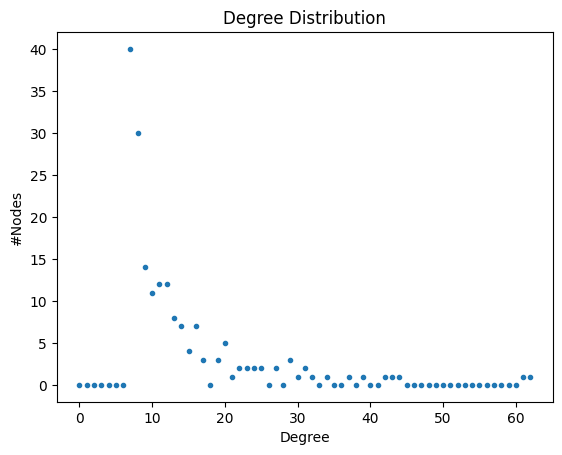

In [130]:
hist = nx.degree_histogram(ba)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# Prova

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
16469
16469
16469
16469
16468
16409
14639
12110
11144
10362
9589
8892
8255
7689
7446
7250
7037
6816
6377
5310
2


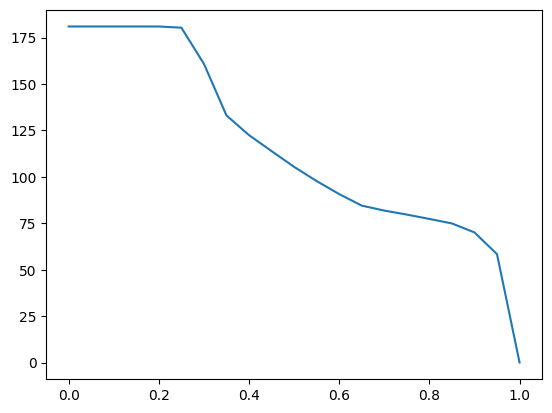

In [131]:
thresholds = np.linspace(0,1, 21)
print(thresholds)
avg_deg = []
n_edg = [] #number of edges

for threshold in thresholds:
    F = G.copy()
    #print(F.number_of_edges())
    F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
    print(F.number_of_edges())
    deg = sum(dict(F.degree()).values())/float(len(G)) #avg degree
    avg_deg.append(deg)
    n_edg.append(F.number_of_edges())
plt.plot(thresholds, avg_deg)
plt.show()
#plt.plot(thresholds, n_edg)
#plt.show()

# Communities

16469
8256


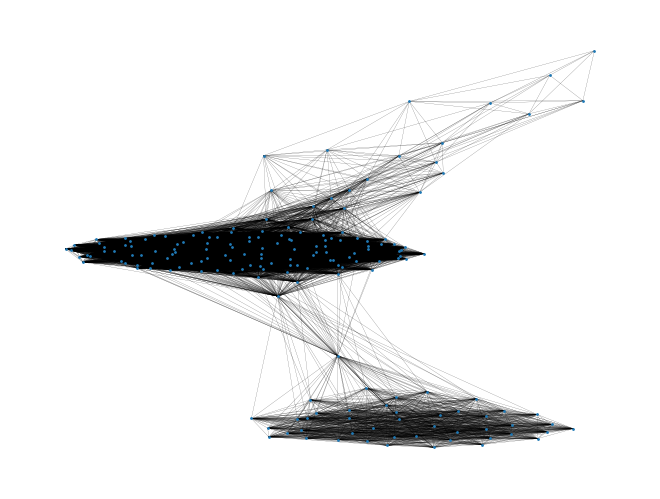

In [132]:
F = G.copy()
threshold = tresh
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

In [133]:
louvain = algorithms.louvain(F)

In [134]:
louvain.communities

[[0,
  2,
  3,
  4,
  6,
  7,
  9,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  30,
  31,
  32,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  45,
  46,
  47,
  49,
  50,
  52,
  57,
  58,
  59,
  62,
  63,
  64,
  65,
  66,
  67,
  69,
  74,
  75,
  78,
  79,
  80,
  81,
  85,
  86,
  88,
  89,
  90,
  92,
  93,
  95,
  96,
  98,
  102,
  103,
  105,
  106,
  109,
  110,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  125,
  126,
  127,
  133,
  137,
  138,
  139,
  140,
  145,
  146,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  165,
  166,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  178,
  179,
  181],
 [10,
  53,
  54,
  55,
  56,
  60,
  61,
  68,
  70,
  71,
  72,
  73,
  82,
  83,
  84,
  87,
  91,
  94,
  97,
  99,
  100,
  101,
  104,
  107,
  108,
  111,
  123,
  124,
  128,
  129,
  130,
  131,
  132,
  134,
  135,
  136,
  141,
  142,
  143,
  144,
  14

In [135]:
louvain.average_internal_degree(summary=False)

[113.6, 43.06666666666667, 14.545454545454545]

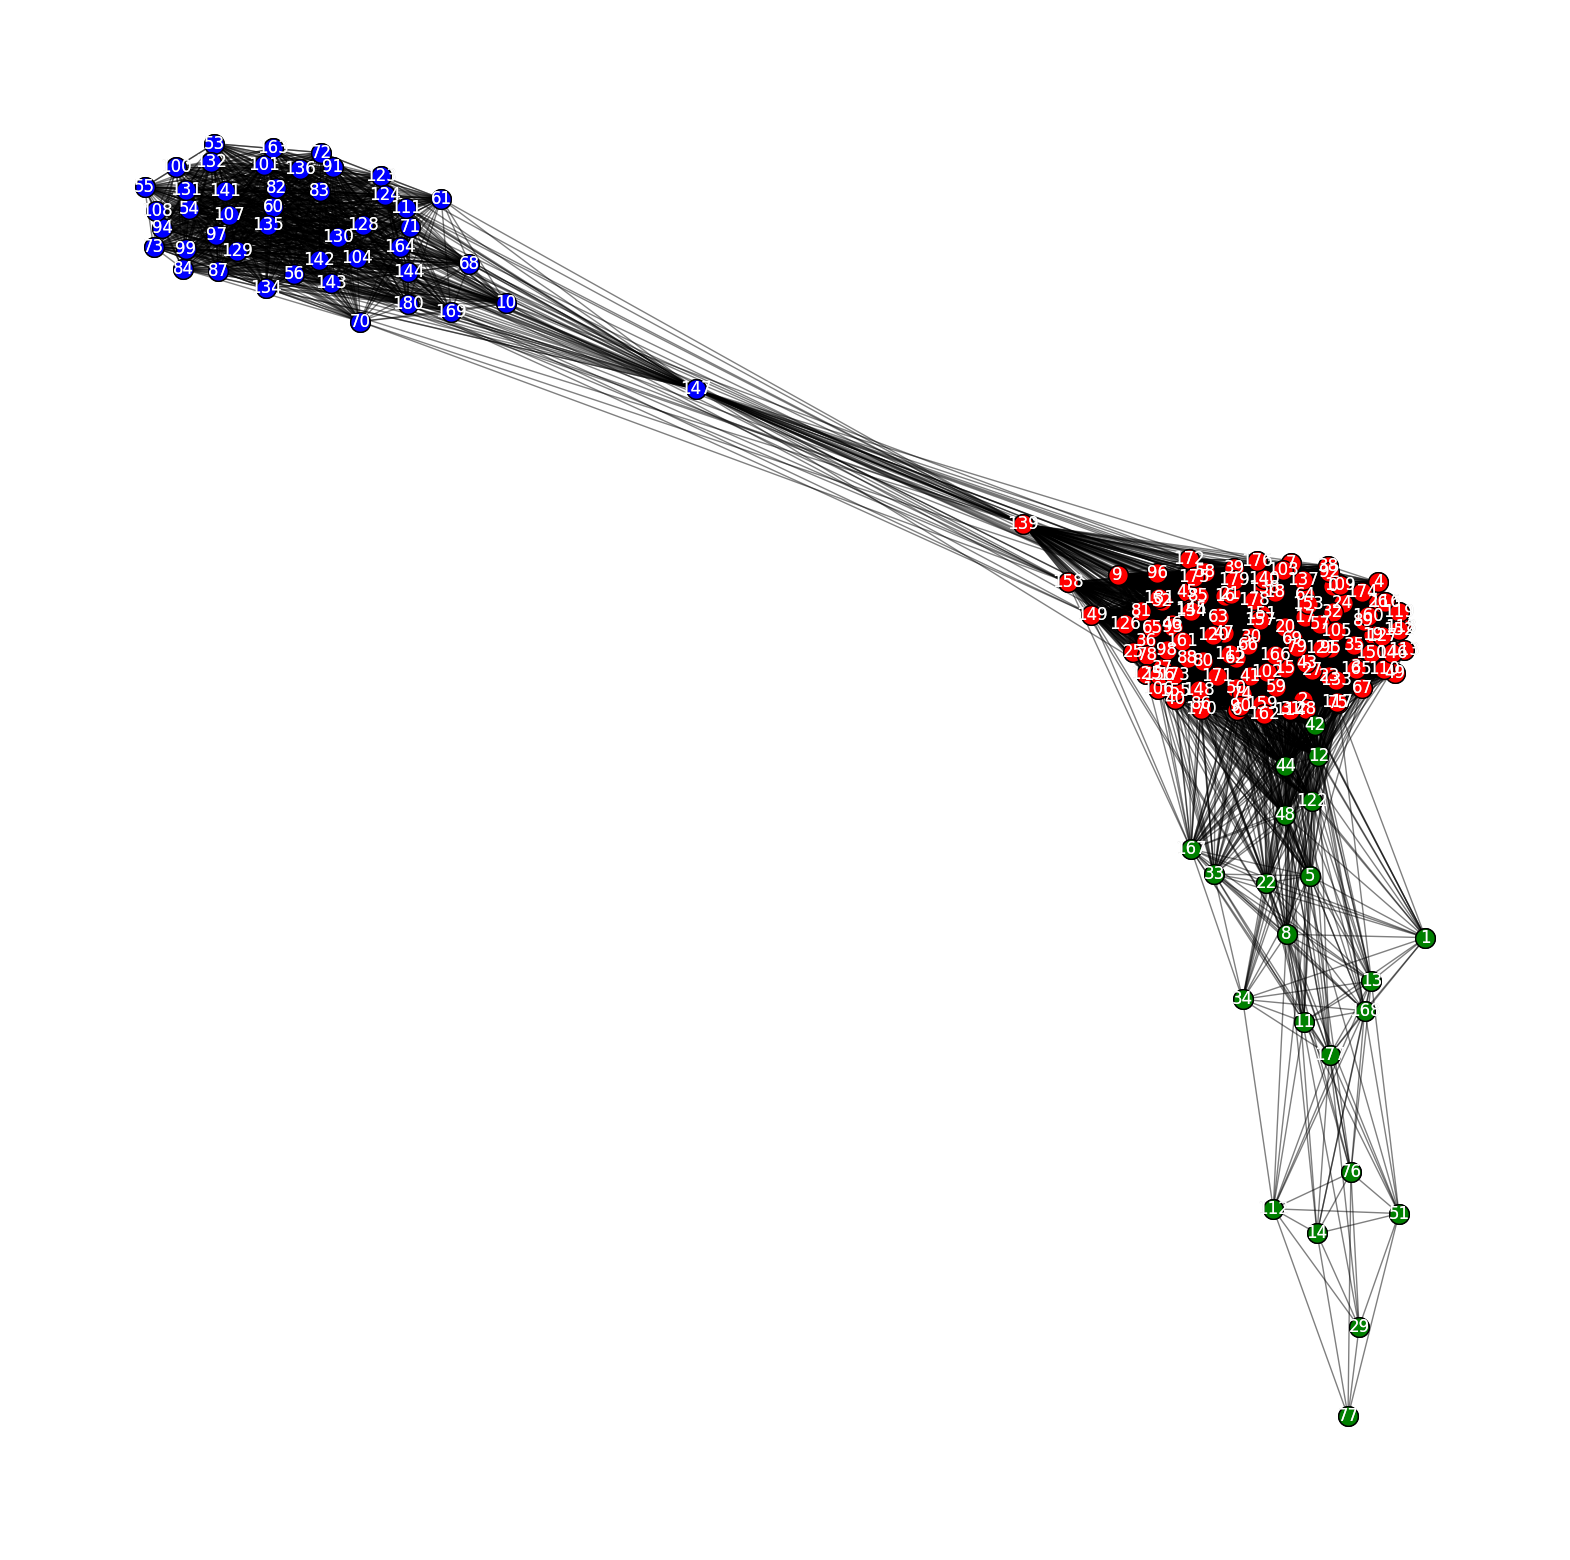

In [136]:
from cdlib import viz


pos = nx.spring_layout(F)
viz.plot_network_clusters(F, louvain, pos, figsize=(20, 20), plot_labels=True, min_size=5)